In [1]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random
from jax import lax
import matplotlib.pyplot as plt

from svgd import SVGD
from utils import ard
from jax.ops import index, index_add, index_update


# What's the issue with `get_bandwidth` in multiple dimensions?

In [127]:
def get_bandwidth(x):
    """
    IN: np array of shape (n,) or (n,d): set of particles
    OUT: scalar: Updated bandwidth parameter for RBF kernel, based on update rule from the SVGD paper.
    """
    if x.ndim == 2:
        return vmap(get_bandwidth, 1)(x)
    elif x.ndim == 1:
        n = x.shape[0]
        h = np.median(squared_distance_matrix(x)) / np.log(n)
        return h
    else:
        raise ValueError("Shape of x has to be either (n,) or (n, d)")

In [128]:
from utils import ard

In [141]:
x = np.array([0])
y = np.array([1])
h = np.array([2])
ard(x, y, h)

DeviceArray(0.8824969, dtype=float32)

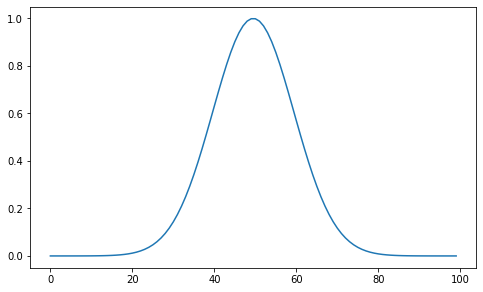

In [142]:
plt.plot([ard(x, np.array([y]), h) for y in np.linspace(-10, 10, 100)])

# Issue with multidim Gaussians

Define multivariate standard gaussian target function:

In [2]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1))

In [4]:
param_dict_error = {
    "n": 10,
    "d": 2,
    "stepsize": 0.01, # still fails when scaling stepsize and L by 10 or 100
    "L": 1000
}

n = 100
d = 2


stepsize = 0.01
L = 1000
from svgd import get_bandwidth

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
assert stepsize * L == 10

## Variable bandwidth

In [6]:
svgd_adaptive = SVGD(logp=logp, n_iter=L, adaptive_kernel=True, get_bandwidth=get_bandwidth)

In [7]:
xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0)

### plotting and MSEs

In [8]:
dim = 0
np.var(xout[:, dim])

DeviceArray(0.7797031, dtype=float32)

Compilation params:
n_iter = 1000

Flexible params:
n = 100
d = 2
stepsize=0.01
---------------------


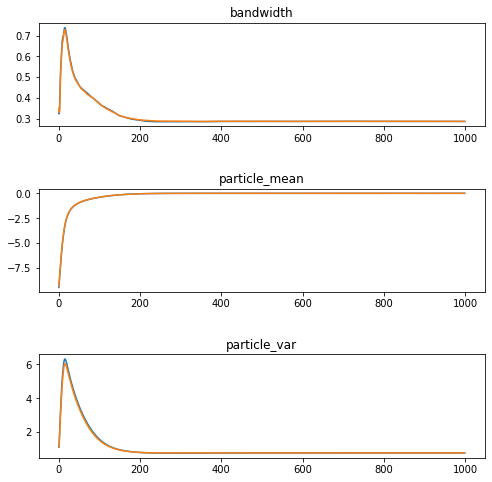

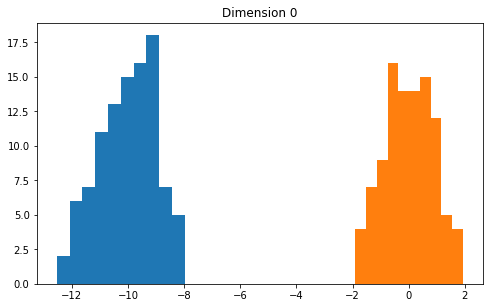

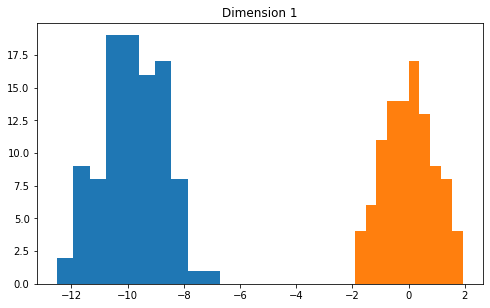

In [9]:
print("Compilation params:")
print(f"n_iter = {svgd_adaptive.n_iter}\n")
print("Flexible params:")
print(f"n = {n}\nd = {d}\nstepsize={stepsize}")
print("---------------------")
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 8]

plt.figure(1)
plt.subplots_adjust(hspace=0.6)

l = len(log)
for i, key in enumerate(log.keys()):
    log[key] = np.array(log[key])
    
    plt.subplot(f"{l}1{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(log[key])

for dim in range(2):
    mpl.rcParams['figure.figsize'] = [8.0, 4.8]
    plt.figure(dim+2)
    plt.title(f"Dimension {dim}")
    _ = plt.hist(x0[:, dim])
    _ = plt.hist(xout[:, dim])

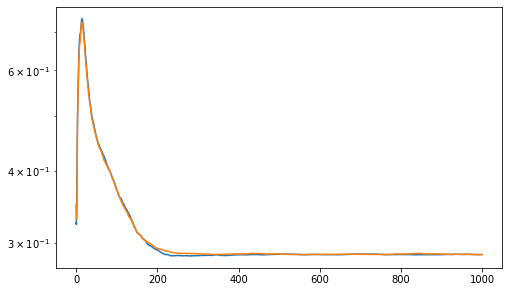

In [10]:
_ = plt.plot(log["bandwidth"])
_ = plt.yscale("log")

## Fixed bandwidth

In [11]:
n = 100
d = 4
stepsize = 0.01
L = 1000

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

In [12]:
svgd_fix = SVGD(logp=logp, n_iter=L, adaptive_kernel=False, get_bandwidth=None)

In [13]:
xoutf, logf = svgd_fix.svgd(x0, stepsize, bandwidth=1)

### plotting

Compilation params:
n_iter = 1000

Flexible params:
n = 100
d = 4
stepsize=0.01
---------------------


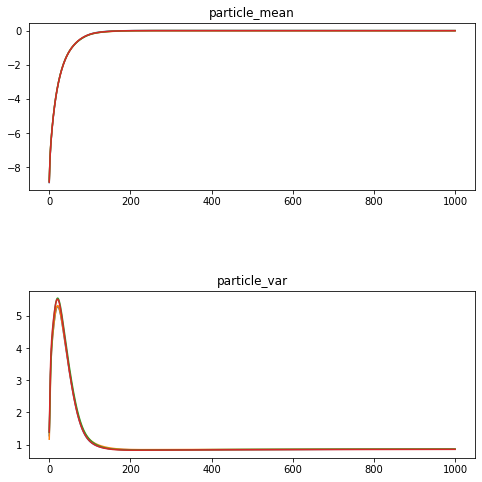

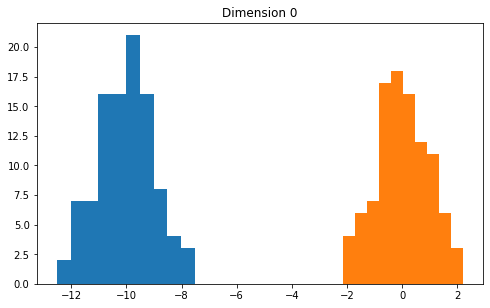

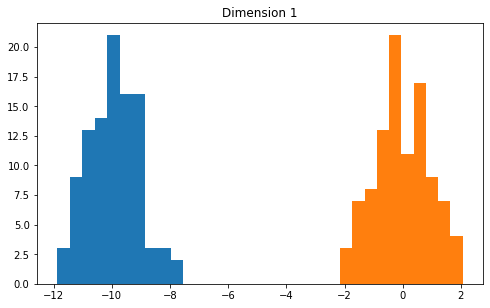

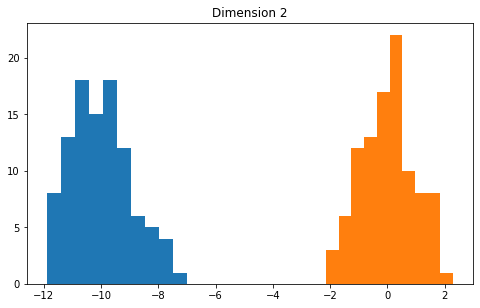

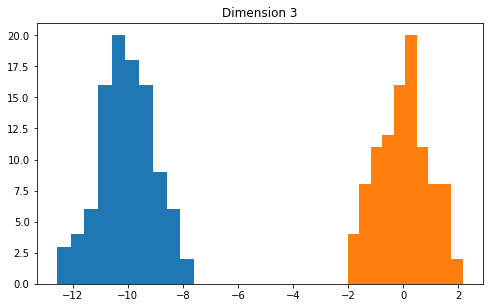

In [14]:
print("Compilation params:")
print(f"n_iter = {svgd_fix.n_iter}\n")
print("Flexible params:")
print(f"n = {n}\nd = {d}\nstepsize={stepsize}")
print("---------------------")

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 8]

plt.figure(1)
plt.subplots_adjust(hspace=0.6)

l = len(logf)
for i, key in enumerate(logf.keys()):
    logf[key] = np.array(logf[key])
    plt.subplot(f"{l}1{i+1}") # 2 plots on 0th axis, 1 plot on 1th axis, plot nr 1 --> 211
    plt.title(key)
    plt.plot(logf[key])

for dim in range(d):
    mpl.rcParams['figure.figsize'] = [8.0, 4.8]
    plt.figure(dim+2)
    plt.title(f"Dimension {dim}")
    _ = plt.hist(x0[:, dim])
    _ = plt.hist(xoutf[:, dim])

# test new SVGD

In [5]:
n = 10
d = 1
stepsize = 0.01
L = int(1 / stepsize)

# generate data
key = random.PRNGKey(0)
x = random.normal(key, (n,d)) - 10

from jax.scipy.stats import norm
from svgd import kernel_param_update_rule

@jit
def logp(x):
    """
    IN: single scalar np array x. alternatively, [x] works too
    OUT: scalar logp(x)
    """
    return np.squeeze(np.sum(norm.logpdf(x, loc=0, scale=1)))

In [12]:
d = x.shape[1]
log = {
    "kernel_param": np.empty(shape=(L, d)),
    "particle_mean": np.empty(shape=(L, d)),
    "particle_var": np.empty(shape=(L, d))
}

def update_fun(i, u):
    """
    1) compute kernel_param from x
    2) compute updated x,
    3) log everything

    Parameters:
    * i: iteration counter (unused)
    * u = [x, log]
    """
    x, log = u
    kernel_param = kernel_param_update_rule(x)
    x = update(x, logp, stepsize, kernel_param)

    particle_mean = np.mean(x, axis=0)
    particle_var = np.var(x, axis=0)

    log["kernel_param"] = index_update(log["kernel_param"], index[i, :], kernel_param)
    log["particle_mean"] = index_update(log["particle_mean"], index[i, :], particle_mean)
    log["particle_var"] = index_update(log["particle_var"], index[i, :], particle_var)

    return [x, log]

x, log = lax.fori_loop(0, L, update_fun, [x, log])


In [11]:
log["particle_var"] - log[particle_var]

NameError: name 'particle_var' is not defined

# multidim SVGD concentrates around max a posteriori

## test ard

In [18]:
n = 10
d = 2

# generate data
key = random.PRNGKey(3)
x = random.normal(key, (n,d)) - 10

In [19]:
x.shape

(10, 2)

In [22]:
ard(x[0], x[0], 1)

DeviceArray(1., dtype=float32)

## here's the problem:

In [23]:
from jax.scipy.stats import norm
from svgd import kernel_param_update_rule

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    return np.sum(norm.logpdf(x, loc=0, scale=1))

In [36]:
n = 10
d = 2
stepsize = 0.01
L = int(10 / stepsize)

# generate data
key = random.PRNGKey(0)
x0 = random.normal(key, (n,d)) - 10

x=x0
# kernel_param=kernel_param_update_rule(x)
kernel_param=2
kernel_param_update_rule = None

In [37]:
log = {
    "kernel_params": [],
    "particle_mean": [np.mean(x, axis=0)],
    "particle_var": [np.var(x, axis=0)]
}

for i in range(L):
    x = update(x, logp, stepsize, kernel_param)
    
    # update
    kernel = lambda x, y: ard(x, y, kernel_param)

    xnew = []
    n = x.shape[0]
    for i, xi in enumerate(x):
        repeated = np.tile(xi, (n, 1))
        xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
    xnew = np.array(xnew)
    xnew += x
    #####
    x = xnew
    
    log["particle_mean"].append(np.mean(x, axis=0))
    log["particle_var"].append(np.var(x, axis=0))

In [38]:
xout=x

log["particle_mean"] = np.array(log["particle_mean"])
log["particle_var"] = np.array(log["particle_var"])
log["kernel_params"] = np.array(log["kernel_params"])

print("vars:")
print('x: ', np.var(xout, axis=0))
print('x0:', np.var(x0, axis=0))
print()
print("means:")
print('x: ', np.mean(xout, axis=0))
print('x0:', np.mean(x0, axis=0) + 10)

vars:
x:  [0.93684864 0.90393126]
x0: [1.5073496 1.1993192]

means:
x:  [-0.00160565  0.00146102]
x0: [0.3955822  0.07276726]


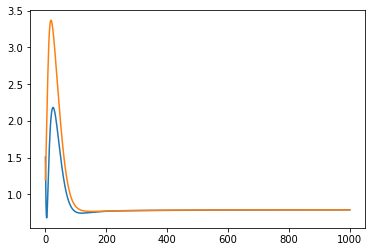

In [33]:
_ = plt.plot(log["particle_var"])

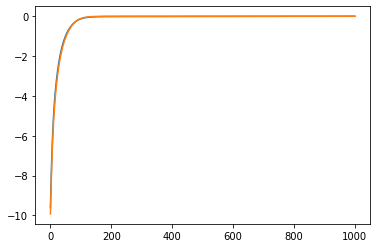

In [35]:
_ = plt.plot(log["particle_mean"])

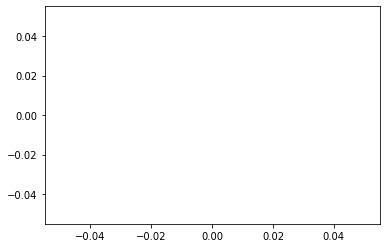

In [34]:
_ = plt.plot(log["kernel_params"])

## generate data

In [ ]:
n = 100
d = 2
key = random.PRNGKey(0)
x0 = random.normal(key, shape=(n, d)) - 10

stepsize = 0.001
L = int(1 / stepsize)

In [ ]:
from jax.scipy.stats import norm

@jit
def logp(x):
    """
    Parameters: 
    * x: np array of shape (d,)
    
    Returns: 
    * scalar log(p(x)), where p(x) is multidim gaussian
    """
    assert x.ndim == 1
    out = np.sum(norm.logpdf(x, loc=0, scale=1))
    return np.squeeze(out) # to be able to take a gradient, output must be scalar

In [ ]:
xout, log = svgd(x0, logp, stepsize, L, kernel_param=None, kernel_param_update_rule=vkernel_param_update_rule)
if "errors" in log.keys():
    print(log["errors"])

In [ ]:
np.var(xout, axis=0)

In [ ]:
np.mean(xout, axis=0)

In [ ]:
len(log["particle_mean"])

In [ ]:
plt.plot(log["particle_mean"])

# testing
where does the NaN come from?

In [ ]:
from utils import ard

In [ ]:
x0.shape

In [ ]:
# x = x0[:, 0]
# x = np.reshape(x, newshape=(n, 1))
x = x0
print(x.shape)
kernel_param = kernel_param_update_rule(x)

In [ ]:
xj = x[0]
xi = x[1]

In [ ]:
xj

In [ ]:
norm.logpdf(xj, loc=0, scale=1)

In [ ]:
logp(xj)

In [ ]:
grad(logp)(xj)

In [ ]:
kernel(xj, xi)

In [ ]:
grad(kernel)(xj, xi)

In [ ]:
kernel_params = []

In [ ]:
# update kernel:
kernel_param = vkernel_param_update_rule(x)
kernel_params.append(kernel_param)
kernel = lambda x, y: ard(x, y, kernel_param)

# update x:
xnew = []
n = x.shape[0]
for i, xi in enumerate(x):
    repeated = np.tile(xi, (n, 1))
    xnew.append(stepsize * np.sum(phi_j_batched(x, repeated, logp, kernel), axis = 0))
xnew = np.array(xnew)
xnew += x
x = xnew

np.mean(x, axis=0)